In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

### 사용할 데이터

xgboostClassifier 모델 학습 때 사용한 데이터와 클러스터링에 사용할 데이터가 약간 차이가 있다.  
전자는 dropna 를 하지 않고 각 클래스별로 500개씩,  
후자는 dropna 처리 후 각 클래스별로 400개를 샘플링하였다.  

In [6]:
# 전체 데이터셋. 결측값 포함, 불균형 Imbalanced
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

print(df_dropna['region'].value_counts())

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

# 결측값 drop. Balanced
df_balanced_dropna = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced_dropna.reset_index(drop=True, inplace=True)

print(df_balanced_dropna['region'].value_counts())

region
0    780
1    440
2    432
Name: count, dtype: int64
            region    education      jobtype       cptype        sales  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      1.000000     0.874167     0.499167     0.865000     1.543819   
std       0.816837     1.179474     0.500208     0.819961     4.334964   
min       0.000000     0.000000     0.000000     0.000000    -0.130200   
25%       0.000000     0.000000     0.000000     0.000000    -0.123950   
50%       1.000000     0.000000     0.000000     1.000000     0.030100   
75%       2.000000     2.000000     1.000000     2.000000     0.647700   
max       2.000000     4.000000     1.000000     2.000000    32.751700   

         employees   aversalary      capital  pros_encoded  
count  1200.000000  1200.000000  1200.000000   1200.000000  
mean      1.116740     0.275184     4.456888      0.367167  
std       2.498558     0.778346    16.214356      0.593815  
min      -0.208500    -1.7826

### 단순 시각화 - 지역별 구인공고를 내건 기업의 규모 (중소(0), 중견(1), 대기업(1)) 비율  
### 가설 2 의 참/거짓을 확인하기 위해 수집한 데이터 분포를 시각화  

[가설 2]  
{수도권, 비수도권 광역시, 그 외 지방} 지역 중에서,  
<수도권> 지역이 '대기업 및 중견기업이 내건 구인공고 비중'이 가장 크고 <그 외 지방> 지역이 해당 공고 비중이 가정 작을 것이다.  

확인 결과,  
예상대로 <수도권>은 다른 두 지역에 비해 대기업 및 중견기업 비율이 가장 컸다.  
또한,  
예상과 달리 <비수도권 광역시> 지역이 <지방> 지역보다 대기업 및 중견기업 비율이 더 작았다.  

#### 즉, 가설 2의 일부분만 예상대로였다.

각 지역별 행데이터 갯수
1424
875
715
cptype
0    0.58
1    0.23
2    0.19
Name: count, dtype: float64
cptype
0    0.65
1    0.18
2    0.18
Name: count, dtype: float64
cptype
0    0.38
2    0.35
1    0.27
Name: count, dtype: float64


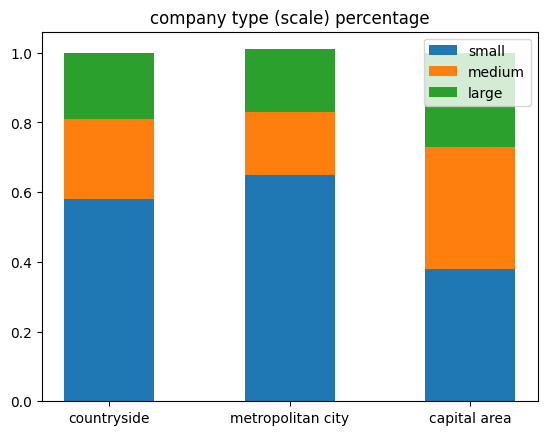

In [20]:
region_0 = df[df["region"] == 0]
region_1 = df[df["region"] == 1]
region_2 = df[df["region"] == 2]

region_0_total = region_0.shape[0]
region_1_total = region_1.shape[0]
region_2_total = region_2.shape[0]

region_0_percentages = np.round(region_0["cptype"].value_counts() / region_0_total, 2)
region_1_percentages = np.round(region_1["cptype"].value_counts() / region_1_total, 2)
region_2_percentages = np.round(region_2["cptype"].value_counts() / region_2_total, 2)

print(region_0_percentages)
print(region_1_percentages)
print(region_2_percentages)

regions = (
    "countryside",
    "metropolitan city",
    "capital area",
)

x = pd.DataFrame(
    {
        "0": region_0_percentages.values,
        "1": region_1_percentages.values,
        "2": region_2_percentages.values,
    }
)

weight_counts = {
    "small": x.iloc[0].values,
    "medium": x.iloc[1].values,
    "large": x.iloc[2].values,
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for cptype, weight_count in weight_counts.items():
    p = ax.bar(regions, weight_count, width, label=cptype, bottom=bottom)
    bottom += weight_count

ax.set_title("company type (scale) percentage")
ax.legend(loc="upper right")

plt.show()


## 가설 3 검증

[가설 3]  
구인 공고 데이터 피쳐를 바탕으로 클러스터링 시에  
크게 그룹 {우수한 일자리 / 중간 / 상대적으로 별로인 일자리} 로  나눌  수 있을 것이며,  
수도권에 가까울수록 우수한 일자리 그룹에 소속된 데이터포인트가 다수일 것이다. (비지도 학습)

만약 가설 3이 사실로 검증된다면, 수집한 데이터가 일자리의 질적 평가를 내릴 수 있을 만큼의 정보량을 가지고 있다는 의미일 것이다.

## k-means clustering

클러스터 갯수는 3개로 설정  
피쳐가 많으므로 시각화를 위해 PCA 를 적용하여 2차원으로 축소.  
주성분 1 의 분산비율이 대부분이었으며, 주성분 1을 구성할 때 큰 비중을 차지하는 피쳐는 'capital' 그 다음은 'sales' 였다.

수도권 : 서울, 인천, 세종, 경기 -> 2  
수도권 외 광역시: 부산, 대구, 광주, 대전, 울산 -> 1  
그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주 -> 0  

지역과는 무관하게    
대부분의 데이터가 속하는 그룹, 아웃라이어 끼리 묶인 그룹, 두 그룹 사이 어딘가에 무작위로 퍼진 그룹으로 분류되었다.  
대부분의 데이터가 속하는 그룹을 제외한 데이터포인터는 분포에 일정한 경향이 없으므로 노이즈, 혹은 아웃라이어로 판단된다.  

In [35]:
df.columns.values

array(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'], dtype=object)

[0.91496003 0.048187  ]
[[-0.01328745 -0.00737264  0.01454735  0.17141677  0.08538181 -0.00699137
   0.98119545  0.00950288]
 [ 0.00588327 -0.03076459  0.17539686  0.84785321  0.4433856   0.02469975
  -0.19050171  0.12612705]]

[0.9394854  0.04163457]
[[-0.01136356 -0.00738207  0.02204868  0.2354632   0.11736063 -0.01610504
   0.96420649  0.01265966]
 [ 0.05728063 -0.01386907  0.10653103  0.90335247  0.31140554  0.03292124
  -0.26056369  0.05640369]]

[0.94921464 0.03710581]
[[-0.00861022 -0.00532056  0.0136608   0.21062234  0.10901591 -0.01616471
   0.9711604   0.00713341]
 [ 0.06300318 -0.00114604  0.04706254  0.85136869  0.45841689  0.00356133
  -0.23654522  0.0536039 ]]



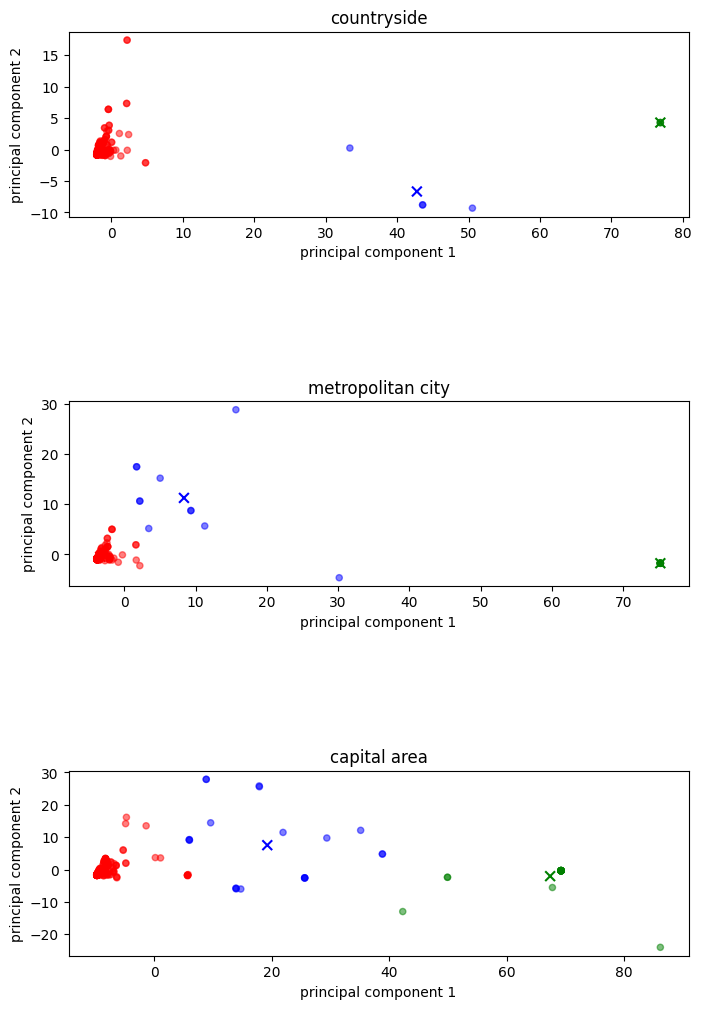

In [34]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca2)
    labels = kmeans.predict(X_pca2)
    dataPointColor = [colors[row] for row in labels]

    centroids = kmeans.cluster_centers_
    centroidColor = [colors[item] for item in range(numClusters)]

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=dataPointColor,
        s=20,
        alpha=0.5,
    )

    # centroids
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        c=centroidColor,
        s=50,
        marker="x",
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

    print(pca_fit.explained_variance_ratio_)
    print(pca_fit.components_)
    print()

plt.show()


### PCA 로 주성분 3개를 갖고 Kmeans 클러스터링 수행  
의미있는 결과는 없었다.

d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


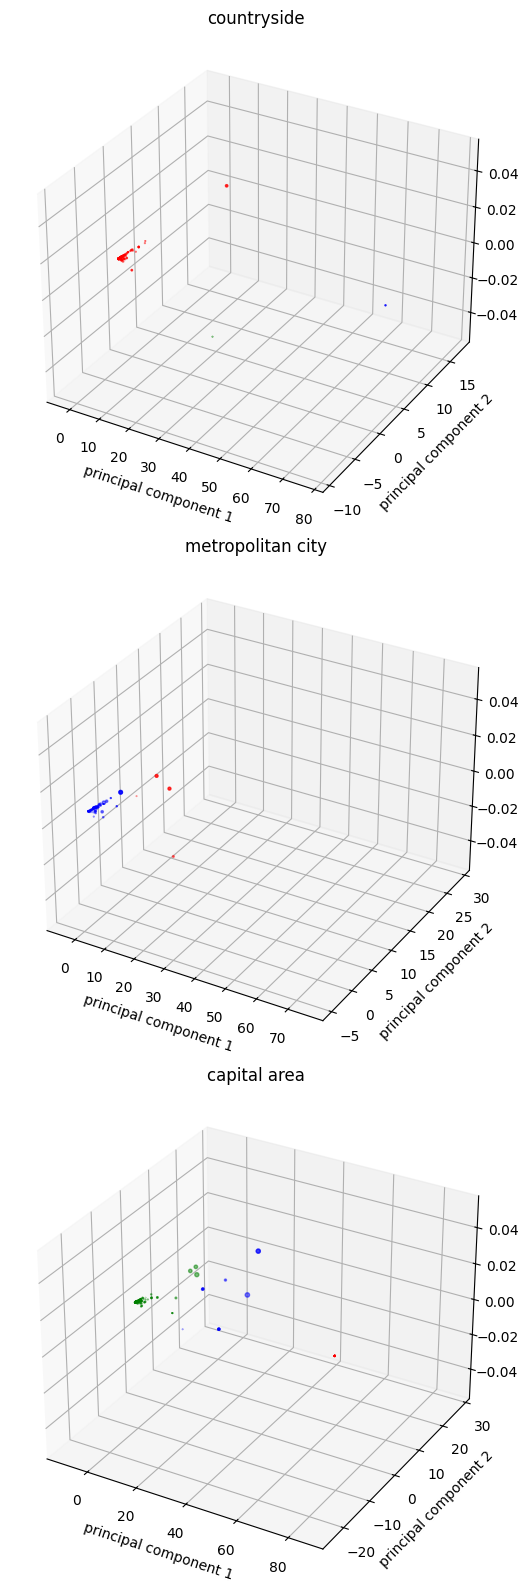

In [27]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # num : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=3)
    pca_fit = pca.fit(X.values)
    X_pca3 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca3,
        columns=[
            "p_component 1",
            "p_component 2",
            "p_component 3",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca3)
    labels = kmeans.predict(X_pca3)
    dataPointColor = [colors[row] for row in labels]

    ax = fig.add_subplot(3, 1, regionType + 1, projection="3d")

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        principalDf["p_component 3"],
        c=dataPointColor,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")
    # ax.set_zlabel("principal component 3")

plt.tight_layout()
plt.show()


## DBSCAN  
사전에 클러스터 갯수를 지정하지 않고 클러스터링을 수행하기 위해 DBSCAN 사용.  

Kmeans 클러스터링 결과까지 함께 고려해봐도,  
#### '지역마다 세 개의 클러스터로 분류되는 경향이 있을 것이다'라는 가설은 틀린 것으로 보인다.  

{0, 1, -1}
The number of clusters (countryside):  2
{0, -1}
The number of clusters (metropolitan city):  1
{0, 1, -1}
The number of clusters (capital area):  2


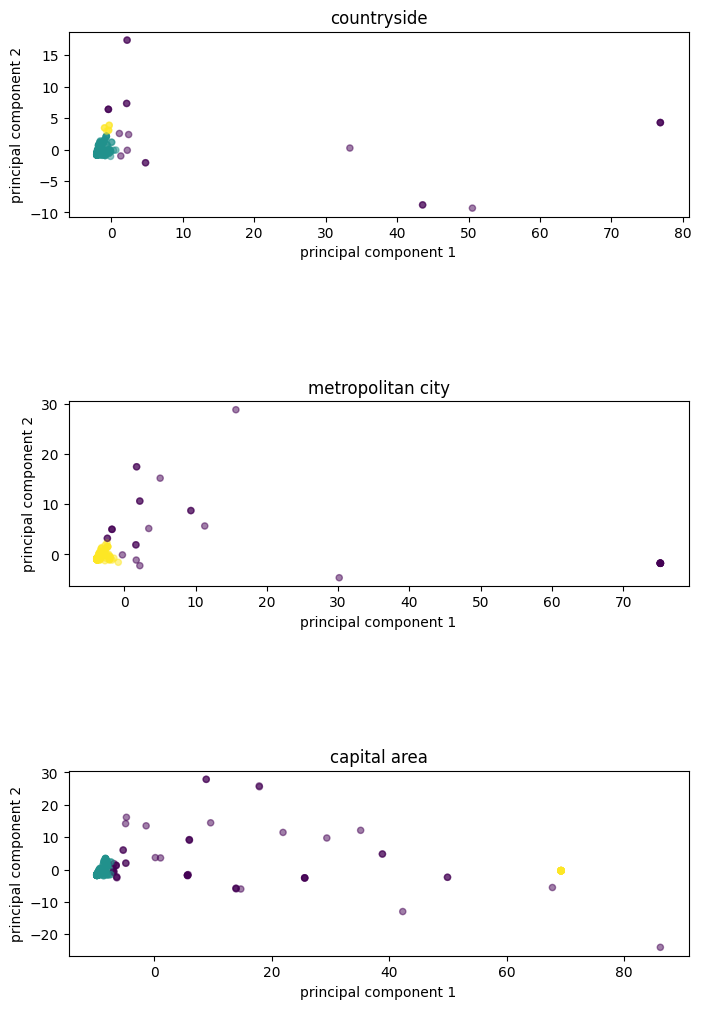

In [28]:
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    predict = DBSCAN(eps=1, min_samples=10).fit_predict(X_pca2)

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=predict,
        s=20,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

    # predict 결과가 -1 인 경우도 존재 (미분류)
    print(set(predict))
    print(f"The number of clusters ({regionTypes[regionType]}): ", len(set(predict)) - 1)

plt.show()